## 0. Imports & cấu hình chung

In [8]:
import os, json, math, itertools, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.10.1


## 1. Đường dẫn & tham số huấn luyện

In [ ]:
DATA_DIR   = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\HoangAnh\chest_xray_v2"  # dùng chung dataset file để train
OUT_DIR    = os.path.join(DATA_DIR, "_resnet50_out")
CKPT_DIR   = os.path.join(OUT_DIR, "checkpoints")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)

BEST_MODEL = os.path.join(CKPT_DIR, "resnet50_pneu_best.h5")
CSV_LOG    = os.path.join(CKPT_DIR, "train_log.csv")

IMG_SIZE = (224, 224)   # ResNet50 mặc định 224
BATCH    = 32
EPOCHS1  = 15           # giai đoạn 1
EPOCHS2  = 15           # giai đoạn 2
LR1      = 1e-3
LR2      = 1e-4
CLASSES  = ["NORMAL", "BACTERIAL", "VIRUS"]  # để tham chiếu

# 2. Tạo dataset (train/val/test) với tf.data

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(subdir, shuffle=True):
    path = os.path.join(DATA_DIR, subdir)
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        labels="inferred",
        label_mode="categorical",      # 3 lớp -> categorical
        class_names=None,              # tự đọc theo tên thư mục
        color_mode="rgb",
        batch_size=BATCH,
        image_size=IMG_SIZE,
        shuffle=shuffle,
        seed=SEED)
    return ds

train_ds = make_ds("train", shuffle=True)
val_ds   = make_ds("val",   shuffle=False)
test_ds  = make_ds("test",  shuffle=False)

class_names = train_ds.class_names
print("class_names (đọc từ thư mục):", class_names)

Found 9097 files belonging to 3 classes.
Found 1359 files belonging to 3 classes.
Found 1355 files belonging to 3 classes.
class_names (đọc từ thư mục): ['NORMAL', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']


In [4]:
# Chuẩn hóa + tăng tốc pipeline
def preprocess(x, y):
    x = tf.cast(x, tf.float32)
    x = resnet_preprocess(x)  # chuẩn hóa theo ResNet50
    return x, y

# Data augmentation
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),
    layers.RandomZoom(0.1),]
                                   )

def with_augment(x, y):
    x = tf.cast(x, tf.float32)
    x = data_augment(x, training=True)
    x = resnet_preprocess(x)
    return x, y

train_ds = train_ds.map(with_augment,  num_parallel_calls=AUTOTUNE).cache().shuffle(1024).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess,      num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess,     num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

## 3. Xây model ResNet50 với 2-phase training

In [5]:
inputs = layers.Input(shape=IMG_SIZE + (3,), name="image")

base = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs
)
base.trainable = False  #giai đoạn 1: đóng băng backbone

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.35)(x)
x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="pred")(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(LR1),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc", multi_label=False)])

model.summary()

94765736/94765736 [==============================] - 879s 9us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['image[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

## 4. Callbacks

In [6]:
cbs = [
    ModelCheckpoint(BEST_MODEL, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=6, mode="max", restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    CSVLogger(CSV_LOG, append=True)]

## 5. Huấn luyện lần 1 (freeze)

In [9]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS1,
    callbacks=cbs)

Epoch 1/15
285/285 [==============================] - ETA: 0s - loss: 0.5737 - accuracy: 0.7526 - auc: 0.9086
Epoch 1: val_accuracy improved from -inf to 0.78587, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\_resnet50_out\checkpoints\resnet50_pneu_best.h5
285/285 [==============================] - 372s 1s/step - loss: 0.5737 - accuracy: 0.7526 - auc: 0.9086 - val_loss: 0.5068 - val_accuracy: 0.7859 - val_auc: 0.9338 - lr: 1.0000e-04
Epoch 2/15
285/285 [==============================] - ETA: 0s - loss: 0.4205 - accuracy: 0.8151 - auc: 0.9486
Epoch 2: val_accuracy improved from 0.78587 to 0.80353, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\_resnet50_out\checkpoints\resnet50_pneu_best.h5
285/285 [==============================] - 365s 1s/step - loss: 0.4205 - accuracy: 0.8151 - auc: 0.9486 - val_loss: 0.4433 - val_accuracy: 0.8035 - val_auc: 0.9457 - lr: 1.0000e-04
Epoch 3/15
285/285 [==============================] - ETA: 0s - los

## 6. Fine-tune – Phase 2 (mở khóa 40–60 lớp cuối ResNet)

In [10]:
n_unfreeze = 50  # mở 50 lớp cuối
for layer in base.layers[-n_unfreeze:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR2),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc", multi_label=False)])

#Fine-tune – Phase 2
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS1 + EPOCHS2,
    initial_epoch=len(history1.epoch),
    callbacks=cbs)

Epoch 16/30
285/285 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9853 - auc: 0.9984
Epoch 16: val_accuracy did not improve from 0.93451
285/285 [==============================] - 352s 1s/step - loss: 0.0500 - accuracy: 0.9853 - auc: 0.9984 - val_loss: 0.2966 - val_accuracy: 0.9286 - val_auc: 0.9815 - lr: 1.0000e-04
Epoch 17/30
285/285 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9861 - auc: 0.9988
Epoch 17: val_accuracy did not improve from 0.93451
285/285 [==============================] - 366s 1s/step - loss: 0.0445 - accuracy: 0.9861 - auc: 0.9988 - val_loss: 0.3703 - val_accuracy: 0.9330 - val_auc: 0.9777 - lr: 1.0000e-04
Epoch 18/30
285/285 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9946 - auc: 0.9994
Epoch 18: val_accuracy did not improve from 0.93451
285/285 [==============================] - 347s 1s/step - loss: 0.0204 - accuracy: 0.9946 - auc: 0.9994 - val_loss: 0.7538 - val_accuracy: 0.8845 - v

## 7.Vẽ learning curves

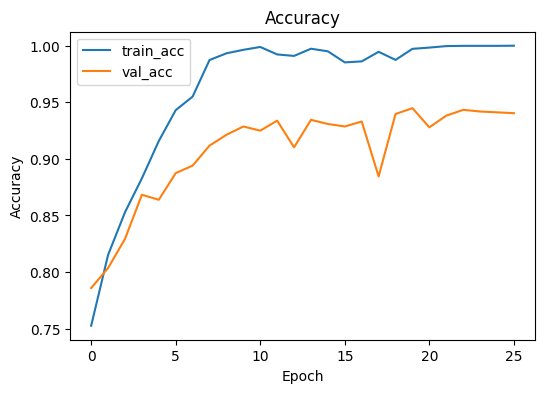

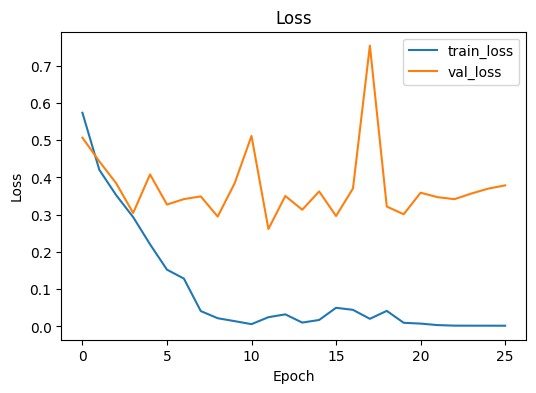

In [11]:
import pandas as pd

def plot_curves(csv_path):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(6,4))
    plt.plot(df["epoch"], df["accuracy"], label="train_acc")
    plt.plot(df["epoch"], df["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy")
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(df["epoch"], df["loss"], label="train_loss")
    plt.plot(df["epoch"], df["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss")
    plt.show()

plot_curves(CSV_LOG)

## 8. Đánh giá trên test set + báo cáo

1. Đánh giá trên test set

In [12]:
best_model = tf.keras.models.load_model(BEST_MODEL, compile=False)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f} - Test loss: {test_loss:.4f}")

Test accuracy: 0.8450 - Test loss: 0.8974


2. Classification

In [13]:
# Lấy y_true và y_pred để in báo cáo
y_true = []
y_pred = []

for batch_x, batch_y in test_ds:
    p = best_model.predict(batch_x, verbose=0)
    y_pred.extend(np.argmax(p, axis=1))
    y_true.extend(np.argmax(batch_y.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


Classification report:
                    precision    recall  f1-score   support

            NORMAL     0.9692    0.8308    0.8947       455
PNEUMONIA_bacteria     0.8558    0.8044    0.8293       450
   PNEUMONIA_virus     0.7472    0.9000    0.8165       450

          accuracy                         0.8450      1355
         macro avg     0.8574    0.8451    0.8468      1355
      weighted avg     0.8578    0.8450    0.8470      1355



array([[378,  22,  55],
       [  6, 362,  82],
       [  6,  39, 405]], dtype=int64)

## 9.Vẽ ma trận nhầm lẫn

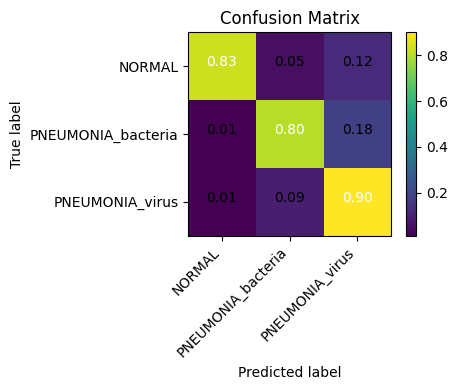

In [17]:
def plot_confusion_matrix(cm, classes, normalize=True):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() * 0.6
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, class_names, normalize=True)

## 10. Grad-CAM cho ảnh ngẫu nhiên trên test set

1. Tham số & chuẩn bị 


In [46]:
import glob
import os, glob, random
import matplotlib.cm as mpl_cm

TEST_DIR = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test"
SAVE_DIR = os.path.join(OUT_DIR, "gradcam_samples")
os.makedirs(SAVE_DIR, exist_ok=True)

LAST_CONV_NAME = "conv5_block3_out"  # lớp conv cuối của ResNet50 trước GAP

# Load best model đã train 
best_model = tf.keras.models.load_model(BEST_MODEL, compile=False)

In [47]:
# Hàm dò lớp conv cuối nếu tên trên không tồn tại 
def pick_last_conv(model, fallback=LAST_CONV_NAME):
    try:
        model.get_layer(fallback)
        return fallback
    except Exception:
        for layer in reversed(model.layers):
            shp = getattr(layer, "output_shape", None)
            if isinstance(shp, tuple) and len(shp) == 4:
                return layer.name
        raise ValueError("Không tìm thấy lớp conv 4D cuối.")
        
LAST_CONV_NAME = pick_last_conv(best_model, LAST_CONV_NAME)
print("lớp conv cuối:", LAST_CONV_NAME)

lớp conv cuối: conv5_block3_out


2. Hàm load và tiền xử lý ảnh

In [48]:
def load_image_for_model(img_path, target_size):
    pil = Image.open(img_path).convert("RGB")
    orig_w, orig_h = pil.size
    resized = pil.resize(target_size, Image.BILINEAR)
    arr = np.array(resized, dtype=np.float32)[None, ...]  # (1, H, W, 3)
    arr = resnet_preprocess(arr)
    return pil, (orig_w, orig_h), arr

3. Tạo bản đồ Grad-CAM từ model

In [49]:
def make_gradcam(img_batch, model, last_conv_name, class_index=None):
    last_conv_layer = model.get_layer(last_conv_name)
    grad_model = Model(model.inputs, [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_batch, training=False)
        if class_index is None:
            class_index = tf.argmax(preds[0])
        score = preds[:, class_index]

    grads = tape.gradient(score, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]

    heatmap = tf.reduce_sum(tf.multiply(conv_out, pooled_grads), axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap) + 1e-10
    return heatmap.numpy()

4. Hàm overlay heatmap lên ảnh gốc

In [53]:
def overlay_heatmap_on_pil(pil_img, heatmap, alpha=0.35):
    W, H = pil_img.size  
    # chuẩn hóa 0..255 và resize về đúng size ảnh
    heatmap_img = Image.fromarray((np.clip(heatmap, 0, 1) * 255).astype(np.uint8)).resize((W, H), Image.BILINEAR)

    # Áp colormap jet bằng matplotlib (trả về RGBA 0..1)
    cmap = mpl_cm.get_cmap("jet")
    heatmap_rgba = cmap(np.array(heatmap_img, dtype=np.float32) / 255.0)
    heatmap_rgb = (heatmap_rgba[..., :3] * 255).astype(np.uint8)  # bỏ kênh alpha

    base = np.array(pil_img).astype(np.float32)
    overlay = (1 - alpha) * base + alpha * heatmap_rgb
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return Image.fromarray(overlay)

5. Chọn ngẫu nhiên 5 ảnh từ tập test

In [54]:
def collect_test_images(root_dir, exts=(".png", ".jpg", ".jpeg", ".bmp")):
    paths = []
    for cls in os.listdir(root_dir):
        subdir = os.path.join(root_dir, cls)
        if not os.path.isdir(subdir): 
            continue
        for f in glob.glob(os.path.join(subdir, "**", "*"), recursive=True):
            if f.lower().endswith(exts):
                paths.append(f)
    return paths

all_imgs = collect_test_images(TEST_DIR)
assert len(all_imgs) > 0, "không có ảnh"
random.shuffle(all_imgs)
sample_paths = all_imgs[:5]
print("5 ảnh được chọn:")
for p in sample_paths: print(" -", p)

5 ảnh được chọn:
 - C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\NORMAL\Normal-10027.png
 - C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\PNEUMONIA_bacteria\person112_bacteria_538.jpeg
 - C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\PNEUMONIA_bacteria\person175_bacteria_834.jpeg
 - C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\NORMAL\NORMAL2-IM-0281-0001.jpeg
 - C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\PNEUMONIA_bacteria\Pneumonia-Bacterial (2692).jpg


6. Dự đoán & vẽ Grad-CAM

C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")


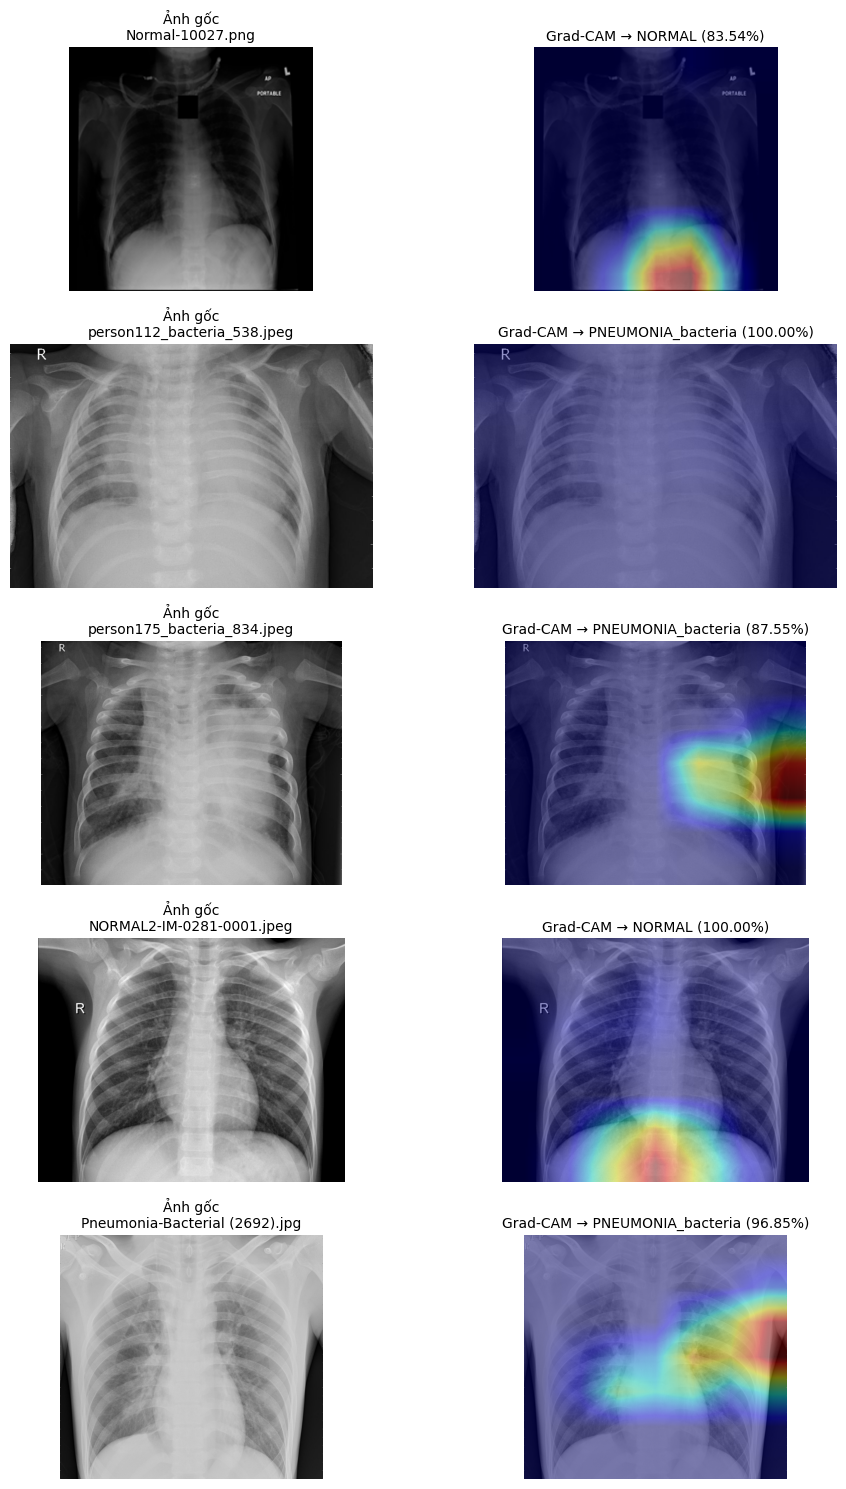

Đã lưu 5 ảnh Grad-CAM tại: C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\_resnet50_out\gradcam_samples


In [55]:
fig, axes = plt.subplots(len(sample_paths), 2, figsize=(10, 3 * len(sample_paths)))
if len(sample_paths) == 1:
    axes = np.array([axes])  # đảm bảo dạng 2D

for i, img_path in enumerate(sample_paths):
    pil, (W, H), arr = load_image_for_model(img_path, IMG_SIZE)
    probs = best_model.predict(arr, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names[pred_idx]
    pred_prob = float(probs[pred_idx])

    heatmap = make_gradcam(arr, best_model, LAST_CONV_NAME, class_index=pred_idx)
    overlay = overlay_heatmap_on_pil(pil, heatmap, alpha=0.4)

    axL, axR = axes[i, 0], axes[i, 1]
    axL.imshow(pil); axL.axis("off")
    axL.set_title(f"Ảnh gốc\n{os.path.basename(img_path)}", fontsize=10)

    axR.imshow(overlay); axR.axis("off")
    axR.set_title(f"Grad-CAM → {pred_name} ({pred_prob:.2%})", fontsize=10)

    # Lưu ảnh Grad-CAM ra thư mục
    overlay.save(os.path.join(SAVE_DIR, f"gradcam_{i+1}_{pred_name}.jpg"), quality=95)

plt.tight_layout()
plt.show()

print(f"Đã lưu {len(sample_paths)} ảnh Grad-CAM tại: {SAVE_DIR}")

## 11 toàn bộ test vào file gradcam_resnet

1) Cấu trúc đích & mapping tên lớp

In [121]:
import os, glob, numpy as np, matplotlib.pyplot as plt
from PIL import Image

# 0) Đường dẫn vào/ra (đổi nếu bạn muốn)
TEST_DIR    = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test"
EXPORT_ROOT = os.path.join(OUT_DIR, "gradcam_resnet")   # ví dụ: .../outputs/gradcam_resnet
os.makedirs(EXPORT_ROOT, exist_ok=True)

1) Chuẩn hoá nhãn THẬT (từ tên thư mục test) về miền: NORMAL / BACTERIAL / VIRUS

In [ ]:
def truth_canon_from_path(p: str) -> str:
    folder = os.path.basename(os.path.dirname(p)).lower()
    if "bact" in folder: return "BACTERIAL"
    if "vir"  in folder: return "VIRUS"
    return "NORMAL"

#Chuẩn hoá nhãn  về cùng miền trên
def pred_canon_from_model_name(name: str) -> str:
    u = str(name).upper()
    if ("BACTERIA" in u) or ("BACTERIAL" in u): return "BACTERIAL"
    if ("VIRUS" in u): return "VIRUS"
    return "NORMAL"

# Tên thư mục xuất
def export_name_from_canon(canon: str) -> str:
    return {
        "NORMAL":    "NORMAL",
        "BACTERIAL": "PNEUMONIA_bacteria",
        "VIRUS":     "PNEUMONIA_virus",
    }[canon]

2) Dò lớp conv cuối cho đảm bảo an toàn

In [125]:
LAST_CONV_NAME = pick_last_conv(best_model, fallback="conv5_block3_out")

3) Liệt kê toàn bộ ảnh test

In [126]:
def list_test_images(root_dir, exts=(".png",".jpg",".jpeg",".bmp")):
    files = []
    for cls in os.listdir(root_dir):
        sub = os.path.join(root_dir, cls)
        if not os.path.isdir(sub): continue
        for f in glob.glob(os.path.join(sub, "**", "*"), recursive=True):
            if f.lower().endswith(exts):
                files.append(f)
    return files

test_paths = list_test_images(TEST_DIR)
print("Tổng ảnh test:", len(test_paths))
assert len(test_paths) > 0, "Không tìm thấy ảnh trong TEST_DIR."

Tổng ảnh test: 1355


4) Helper và lưu trữ

In [127]:
def save_pair_side_by_side(orig_pil, overlay_pil, left, right, save_path):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(orig_pil);   plt.axis("off"); plt.title(left,  fontsize=14, weight="bold")
    plt.subplot(1,2,2); plt.imshow(overlay_pil); plt.axis("off"); plt.title(right, fontsize=14, weight="bold")
    plt.tight_layout(); plt.savefig(save_path, dpi=150, bbox_inches="tight"); plt.close()

7) Chạy toàn bộ và xuất ảnh

In [130]:
done = correct_cnt = wrong_cnt = 0
try:
    _CLASS_NAMES_UPPER = [c.upper() for c in class_names]
except Exception:
    _CLASS_NAMES_UPPER = None

for img_path in test_paths:
    # Nhãn thật 
    y_true_canon = truth_canon_from_path(img_path)
    dst_true_name = export_name_from_canon(y_true_canon)

    # Chuẩn bị ảnh + dự đoán
    pil, _, arr = load_image_for_model(img_path, IMG_SIZE)
    probs = best_model.predict(arr, verbose=0)[0]
    pred_idx = int(np.argmax(probs))

    # tên lớp thô lấy từ model chuẩn hoá về canon
    if _CLASS_NAMES_UPPER and pred_idx < len(_CLASS_NAMES_UPPER):
        raw_pred_name = _CLASS_NAMES_UPPER[pred_idx]
    else:
        raw_pred_name = f"CLASS_{pred_idx}"
    y_pred_canon = pred_canon_from_model_name(raw_pred_name)
    pred_show = export_name_from_canon(y_pred_canon)

    # Grad-CAM theo lớp dự đoán
    heatmap = make_gradcam(arr, best_model, LAST_CONV_NAME, class_index=pred_idx)
    overlay = overlay_heatmap_on_pil(pil, heatmap, alpha=0.40)

  # Đúng/sai & đường lưu
    split = "correct" if y_pred_canon == y_true_canon else "wrong"
    if split == "correct":
        correct_cnt += 1
    else:
        wrong_cnt += 1

    save_dir = os.path.join(EXPORT_ROOT, dst_true_name, split)
    os.makedirs(save_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(img_path))[0]
    save_path = os.path.join(save_dir, f"{base}__pred-{pred_show}({probs[pred_idx]:.2f}).jpg")
    
 #Lưu cặp ảnh
    save_pair_side_by_side(pil, overlay, "Original", f"Grad-CAM → {pred_show} ({probs[pred_idx]:.2f})", save_path)

    done += 1
    if done % 50 == 0:
        print(f"Đã xử lý {done}/{len(test_paths)} ảnh...")

print(f"\nTổng: {done} | Đúng: {correct_cnt} | Sai: {wrong_cnt}")
print("Đã xuất vào:", EXPORT_ROOT)

C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 50/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 100/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 150/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 200/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 250/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 300/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 350/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 400/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 450/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 500/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 550/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 600/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 650/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 700/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 750/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 800/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 850/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 900/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 950/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1000/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1050/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1100/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1150/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1200/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1250/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1300/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057

Đã xử lý 1350/1355 ảnh...


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")
C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\344057


Tổng: 1355 | Đúng: 1143 | Sai: 212
Đã xuất vào: C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\gradcam_resnet


C:\Users\VACB\AppData\Local\Temp\ipykernel_13724\3440572354.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl_cm.get_cmap("jet")


## 12.Xác thực chéo cho ResNet50

1. Thu thập file & nhãn (gộp train + val)

In [99]:
#thư viên bổ sung
import os, glob, pandas as pd
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

DATA_DIR = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")  
TEST_DIR  = os.path.join(DATA_DIR, "test")

In [85]:
# mapping chuẩn tên class dùng lúc train
CANON_CLASSES = ["NORMAL", "BACTERIAL", "VIRUS"]   # khớp class_names trước đó
ALIAS_TO_CANON = {
    "normal":"NORMAL",
    "pneumonia_bacteria":"BACTERIAL","pneumonia-bacteria":"BACTERIAL","bacterial":"BACTERIAL","bacteria":"BACTERIAL",
    "pneumonia_virus":"VIRUS","pneumonia-virus":"VIRUS","viral":"VIRUS","virus":"VIRUS"}

In [86]:
def list_images_with_label(root):
    rows = []
    if not os.path.isdir(root): return rows
    for cls in os.listdir(root):
        p = os.path.join(root, cls)
        if not os.path.isdir(p): continue
        key = cls.lower()
        canon = ALIAS_TO_CANON.get(key, cls.upper())
        for f in glob.glob(os.path.join(p, "**", "*"), recursive=True):
            if f.lower().endswith((".png",".jpg",".jpeg",".bmp")):
                rows.append((f, canon))
    return rows

rows = list_images_with_label(TRAIN_DIR)
rows += list_images_with_label(VAL_DIR)    

df = pd.DataFrame(rows, columns=["path","label"])
df = df[df["label"].isin(CANON_CLASSES)].reset_index(drop=True)
print(df.head(), "\nTổng ảnh train+val:", len(df))
label_to_idx = {c:i for i,c in enumerate(CANON_CLASSES)}

                                                path   label
0  C:\Users\VACB\OneDrive\Desktop\xception_v2\che...  NORMAL
1  C:\Users\VACB\OneDrive\Desktop\xception_v2\che...  NORMAL
2  C:\Users\VACB\OneDrive\Desktop\xception_v2\che...  NORMAL
3  C:\Users\VACB\OneDrive\Desktop\xception_v2\che...  NORMAL
4  C:\Users\VACB\OneDrive\Desktop\xception_v2\che...  NORMAL 
Tổng ảnh train+val: 10456


2. Helper: tf.data từ danh sách file, model builder

In [87]:
#kích thước chuẩn 
IMG_SIZE = (224,224)
BATCH = 32

In [88]:
# Đọc ảnh từ đường dẫn -> resize -> chuẩn hoá -> gán nhãn (one-hot)
def decode_image(path, label_idx):
    img = tf.io.read_file(path)                                   
    img = tf.image.decode_image(img, channels=3, expand_animations=False)  # Giải mã thành tensor (H,W,3)
    img = tf.image.resize(img, IMG_SIZE)                         
    img = tf.cast(img, tf.float32)
    img = resnet_preprocess(img)                                    # Chuẩn hoá theo ImageNet
    y = tf.one_hot(label_idx, depth=len(CANON_CLASSES))             # Chuyển label số -> vector one-hot
    return img, y

In [89]:
#Tạo dataset từ danh sách đường dẫn 
def make_ds_from_paths(paths, labels, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), reshuffle_each_iteration=True)
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)

    if augment:
        aug = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.02),
            layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)

    return ds.batch(BATCH).prefetch(AUTOTUNE)

In [91]:
#Hàm build model ResNet50
def build_resnet50(lr=1e-3, train_backbone=False, n_unfreeze=0):
    inputs = layers.Input(shape=IMG_SIZE + (3,))
    base = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    base.trainable = train_backbone  # freeze toàn bộ backbone

    #fine-tune: mở khóa 1 phần lớp cuối 
    if train_backbone and n_unfreeze > 0:
        for layer in base.layers[:-n_unfreeze]:
            layer.trainable = False
        for layer in base.layers[-n_unfreeze:]:
            if isinstance(layer, layers.BatchNormalization):
                layer.trainable = False
            else:
                layer.trainable = True

    # Thêm khối phân loại phía sau
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-5))(x)
    x = layers.Dropout(0.35)(x)
    outputs = layers.Dense(len(CANON_CLASSES), activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="categorical_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['image[0][0]']                  
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

3. K-Fold split (Stratified) & callback

In [101]:
K = 5
RANDOM_STATE = 42
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

#cấu trúc lưu kết quả
OUT_DIR = os.path.join(DATA_DIR, "outputs")
CKPT_DIR = os.path.join(OUT_DIR, "checkpoints_kfold")
LOG_DIR  = os.path.join(OUT_DIR, "logs_kfold")
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

y_idx = df["label"].map(label_to_idx).values
X_paths = df["path"].values

In [107]:
fold_metrics = []
EPOCHS1, LR1 = 12, 1e-3    # Giai đoạn 1: freeze backbone
EPOCHS2, LR2, UNFREEZE = 4, 1e-4, 50  # Giai đoạn 2: fine-tune 50 lớp cuối

4. Huấn luyện

In [ ]:
for fold, (tr_idx, va_idx) in enumerate(skf.split(X_paths, y_idx), start=1):
    print(f"\n FOLD {fold}/{K} ")
    tr_paths, va_paths = X_paths[tr_idx], X_paths[va_idx]
    tr_y, va_y = y_idx[tr_idx], y_idx[va_idx]

    ds_tr = make_ds_from_paths(tr_paths, tr_y, shuffle=True, augment=True)
    ds_va = make_ds_from_paths(va_paths, va_y, shuffle=False, augment=False)

# giai đoạn 1: freeze backbone
    model = build_resnet50(lr=LR1, train_backbone=False)
    cbs = [
        ModelCheckpoint(os.path.join(CKPT_DIR, f"resnet50_fold{fold}_best.h5"), monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
        EarlyStopping(monitor="val_accuracy", mode="max", patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        CSVLogger(os.path.join(LOG_DIR, f"train_fold{fold}.csv"), append=False),
    ]
    model.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS1, callbacks=cbs, verbose=1)   
# Giai đoạn 2: Fine-tune, mở 50 lớp cuối
    model = build_resnet50(lr=LR2, train_backbone=True, n_unfreeze=UNFREEZE)
    model.load_weights(os.path.join(CKPT_DIR, f"resnet50_fold{fold}_best.h5"), by_name=True, skip_mismatch=True)

    cbs2 = [
        ModelCheckpoint(os.path.join(CKPT_DIR, f"resnet50_fold{fold}_best.h5"),monitor="val_accuracy", mode="max", save_best_only=True, verbose=1),
        EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
        CSVLogger(os.path.join(LOG_DIR, f"train_fold{fold}_finetune.csv"))
        ]
    model.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS1+EPOCHS2,initial_epoch=EPOCHS1, callbacks=cbs2, verbose=1)

    val_loss, val_acc, val_auc = model.evaluate(ds_va, verbose=0)
    fold_metrics.append({"fold": fold, "val_acc": float(val_acc), "val_auc": float(val_auc)})
    print(f"[Fold {fold}] val_acc={val_acc:.4f}  val_auc={val_auc:.4f}")


 FOLD 1/5 
Epoch 1/12
262/262 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.7285 - auc: 0.8924
Epoch 1: val_accuracy improved from -inf to 0.78537, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\checkpoints_kfold\resnet50_fold1_best.h5
262/262 [==============================] - 259s 982ms/step - loss: 0.6307 - accuracy: 0.7285 - auc: 0.8924 - val_loss: 0.4897 - val_accuracy: 0.7854 - val_auc: 0.9327 - lr: 0.0010
Epoch 2/12
262/262 [==============================] - ETA: 0s - loss: 0.5356 - accuracy: 0.7685 - auc: 0.9195
Epoch 2: val_accuracy improved from 0.78537 to 0.79541, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\checkpoints_kfold\resnet50_fold1_best.h5
262/262 [==============================] - 258s 986ms/step - loss: 0.5356 - accuracy: 0.7685 - auc: 0.9195 - val_loss: 0.4540 - val_accuracy: 0.7954 - val_auc: 0.9398 - lr: 0.0010
Epoch 3/12
262/262 [==============================] - E

5. Đánh giá trên tập test và trung bình K fold

In [109]:
#Chuẩn bị test set cố định
import pandas as pd, glob

test_rows = []
for cls in os.listdir(TEST_DIR):
    sub = os.path.join(TEST_DIR, cls)
    if not os.path.isdir(sub): continue
    for f in glob.glob(os.path.join(sub, "**", "*"), recursive=True):
        if f.lower().endswith((".png",".jpg",".jpeg",".bmp")): test_rows.append((f, ALIAS_TO_CANON.get(cls.lower(), cls.upper())))

test_df = pd.DataFrame(test_rows, columns=["path","label"])
test_df = test_df[test_df["label"].isin(CANON_CLASSES)].reset_index(drop=True)

test_paths = test_df["path"].values
test_y_idx = test_df["label"].map(label_to_idx).values
ds_test = make_ds_from_paths(test_paths, test_y_idx, shuffle=False, augment=False)

print(" Tổng ảnh test:", len(test_df))

 Tổng ảnh test: 1355


In [110]:
#Đánh giá từng fold và Ensemble trung bình
all_fold_preds = []

for fold in range(1, K+1):
    m = tf.keras.models.load_model(os.path.join(CKPT_DIR, f"resnet50_fold{fold}_best.h5"), compile=False)
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    loss, acc = m.evaluate(ds_test, verbose=0)
    print(f"[Fold {fold}] Test accuracy: {acc:.4f}")

    preds = m.predict(ds_test, verbose=0)
    all_fold_preds.append(preds)

# Trung bình xác suất giữa các fold
mean_preds = np.mean(np.stack(all_fold_preds, axis=0), axis=0)
y_pred = mean_preds.argmax(axis=1)
test_acc_ens = (y_pred == test_y_idx).mean()
print(f"\n Ensemble (soft-vote) Test Accuracy: {test_acc_ens:.4f}")

[Fold 1] Test accuracy: 0.7661
[Fold 2] Test accuracy: 0.7771
[Fold 3] Test accuracy: 0.7793
[Fold 4] Test accuracy: 0.7542
[Fold 5] Test accuracy: 0.7749

 Ensemble (soft-vote) Test Accuracy: 0.7845
